In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import datetime as dt
import sys

from pathlib import Path

import pandas as pd

from river import utils
from river.proba import Gaussian

sys.path.insert(1, str(Path().resolve().parent))
from functions.anomaly import GaussianScorer
from functions.proba import MultivariateGaussian
from functions.evaluate import progressive_val_predict

from publications.ilustrate.pc2023.plot_matplotlib import *

In [8]:
df = pd.read_csv("data/data_BESS_norm.csv", index_col=0)
df.index = pd.to_datetime(df.index, utc=True)

In [ ]:
# CONSTANTS
days = 4
WINDOW = dt.timedelta(hours=24*days)
minutes = int(WINDOW.total_seconds()/60)
GRACE_PERIOD=int(minutes/4)
THRESHOLD = 0.9995

model = GaussianScorer(
    utils.TimeRolling(MultivariateGaussian(), period=WINDOW),
    #utils.Rolling(MultivariateGaussian(), window_size=24*days*60),
    grace_period=GRACE_PERIOD,
    t_a = 60*3,
    threshold=THRESHOLD,
    # log_threshold=np.log(0.99735)
    )


sampling_model = GaussianScorer(
    Gaussian()._from_state(minutes, 60, 60**2, 1),
    protect_anomaly_detector=False)

system_anomaly, meta = progressive_val_predict(
    model=model,
    dataset=df,
    compute_limits=True,
    detect_signal=True,
    detect_change=True,
    sampling_model=sampling_model,
    )

df_out = pd.DataFrame({"System Anomaly": system_anomaly,
                       **meta},
                      index= df.index)

In [10]:
events_count = sum(pd.Series(system_anomaly).diff().dropna() == 1)
text = (
    f"Sliding window: {WINDOW}\n"
    f"Proportion of anomalous samples: "
    f"{sum(system_anomaly)/len(system_anomaly)*100:.02f}%\n"
    f"Anomaly every: "
    f"{len(system_anomaly)/sum(system_anomaly):.00f} samples\n"
    f"Total number of anomalous events: "
    f"{events_count}\n"
    f"Anomalous event every: "
    f"{len(system_anomaly)/events_count:.00f} samples\n"
    f"Total number of change points: "
    f"{sum(df_out['Changepoint'].diff().dropna() == 1)}\n"
    f"Total number of sampling anomalies: "
    f"{sum(df_out['Sampling Anomaly'].diff().dropna() == 1)}"
    )

print(text)

Sliding window: 4 days, 0:00:00
Proportion of anomalous samples: 2.09%
Anomaly every: 48 samples
Total number of anomalous events: 2
Anomalous event every: 6248 samples
Total number of change points: 2
Total number of sampling anomalies: 3


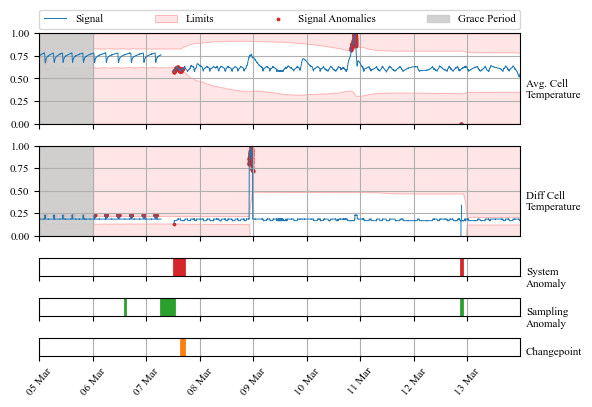

In [93]:
plot_limits_grid_(
    df,
    df_out["Changepoint"], 
    df_out["Sampling Anomaly"],
    df_out['System Anomaly'],
    ser_high=df_out['Limit High'].iloc[1:],
    ser_low=df_out['Limit Low'].iloc[1:],
    signal_anomaly=df_out["Signal Anomaly"],
    file_name="TERRA",
    save=False,
    **{
        'resample': '1t',
        'grace_period': GRACE_PERIOD
        })